In [74]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)


# environment parameters

FRAME_TIME = 0.005  # time interval
GRAVITY_ACCEL = -9.81  # gravity constant
BOOST_ACCEL = 15  # thrust constant
ROTATION_ACCEL = 65*math.pi/180

In [75]:
# define system dynamics
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action[0] = Thrust in y
        action[1] = Thrust in x
        action[2] = Rotational thrust

        state[0] = y
        state[1] = y_vel
        state[2] = x
        state[3] = x_vel
        state[4] = orientation
        state[5] = rot_vel
        """
        
        # Apply gravity
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME, 0., 0.,0.,0.])


        delta_state_y = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.,0.,0.]) * action[0] 
        
        delta_state_x = BOOST_ACCEL * FRAME_TIME * t.tensor([0.,0., 0., 1.,0.,0.]) * action[1]  

        delta_state_rotation = ROTATION_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 0., 0., 1.]) * action[2]

        redundancy_var = delta_state_y

        #Drag
        """
          We know that Drag force is given by the formula: Df= (Co-eff of Drag * Denisty of material * Area * Velocity^2)/2
          Assumptions: Taking GSLV Mk III [ISRO:- Indian Space Research Organisation]
          Co-efficient of Drag =  0.295 //taken from internet
          Area = 1.6*1.6*pi = 8.0457
          Density = 4420 kg/m^3
          mass= 3,22,379 Kg (Chandrayan Indian Project)

          Drag Force = 0.5 * 0.295 * 8.0457 * 4420 * vel^2 
          Drag Force = 5245.394 * Vel^2


          Rev Acceleration due to Drag =  Drag_Force/ mass = 0.01627 * Vel^2
        """

        DRAG_DECEL = 0.01627 * redundancy_var * redundancy_var

        NET_ACCEL = BOOST_ACCEL - DRAG_DECEL

        delta_state_yn = NET_ACCEL * FRAME_TIME * t.tensor([0., t.cos(state[4]), 0., 0.,0.,0.]) * action[0] 


        state = state + delta_state_yn + delta_state_x + delta_state_rotation + delta_state_gravity

        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., FRAME_TIME, 0., 0.],
                            [0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state 
      

In [76]:
class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [77]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
                state = [10., 0., 5., 0.,0.,0.]  # TODO: need batch of initial states
                return t.tensor(state, requires_grad=False).float()

    def error(self, state):
      loss = t.sum(t.square(state))
      return loss

In [78]:
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
    # Establishing data arrays to plot
        statedata = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        actiondata = np.array([self.simulation.action_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        Time = FRAME_TIME * np.linspace(0,T,T)
        x = statedata[:, 0]
        xdot = statedata[:, 1]
        y = statedata[:, 2]
        ydot = statedata[:, 3]
        rot = statedata[:, 4]
        rotdot = statedata[:, 5]
        thrust = actiondata[:, 0]
        rotthrust = actiondata[:,1]
      
        # Creating the plot for each of the state variables
        f1 = plt.figure()
        ax1 = f1.add_subplot(111)
        ax1.plot(Time, y, label = 'y position')
        ax1.plot(Time, ydot, label = 'ydot')
        ax1.plot(Time, x, label = 'x position')
        ax1.plot(Time, xdot, label = 'xdot')
        ax1.plot(Time, rot, label = 'rot')
        ax1.plot(Time, rotdot, label = 'rotdot')
        plt.xlabel('Time, s')
        plt.ylabel('State Variables')
        plt.title('State Variables vs. Time')
        plt.grid(True)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
      
        # Creating the plot for each of the action variables
        f2 = plt.figure()
        ax2 = f2.add_subplot(111)
        ax2.plot(Time, thrust, label = 'thrust')
        ax2.plot(Time, rotthrust, label = 'rotthrust')
        plt.xlabel('Time, s')
        plt.ylabel('Action Variables')
        plt.title('Action Variables vs. Time')
        plt.grid(True)
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
      
        plt.show()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[1] loss: 128.934


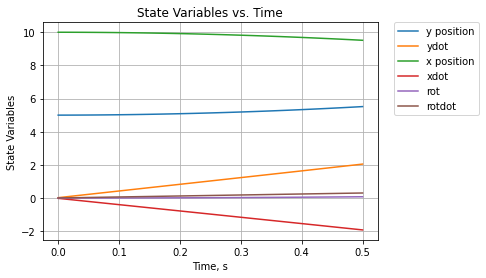

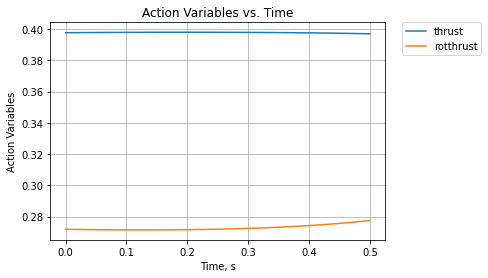

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[2] loss: 124.424


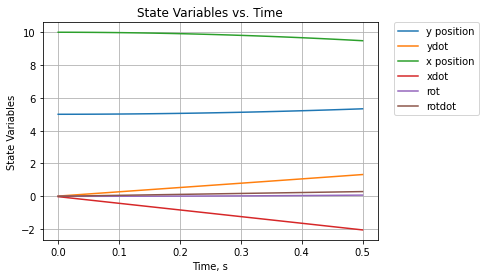

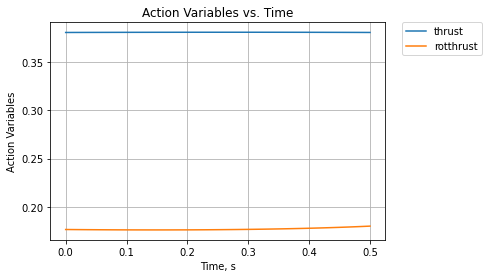

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[3] loss: 122.587


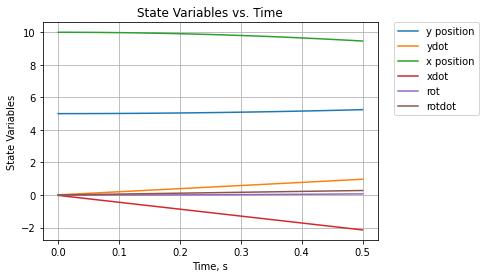

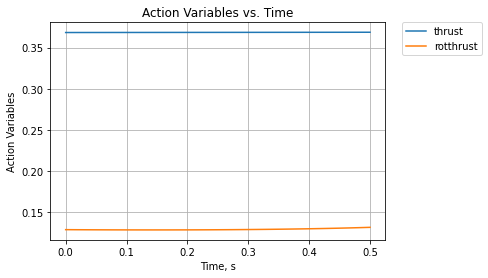

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[4] loss: 121.591


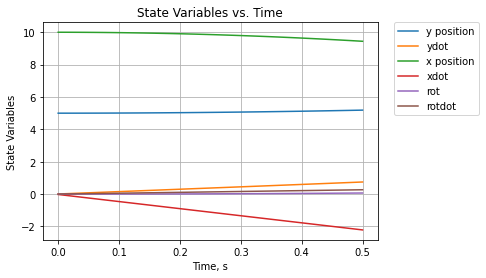

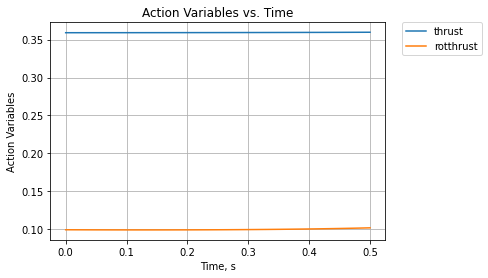

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[5] loss: 120.746


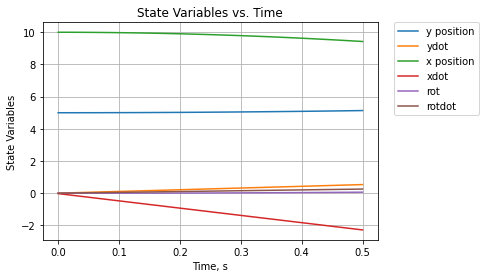

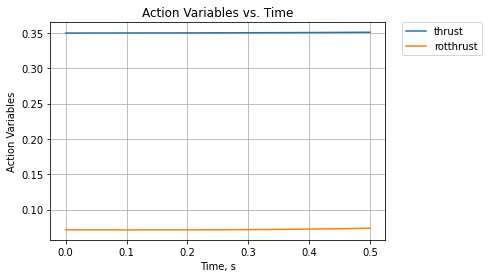

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[6] loss: 120.109


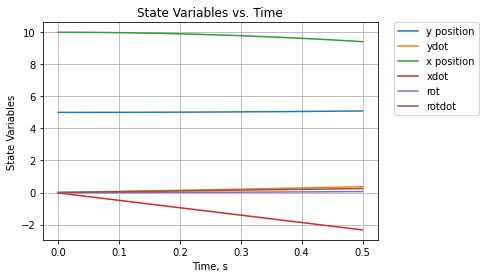

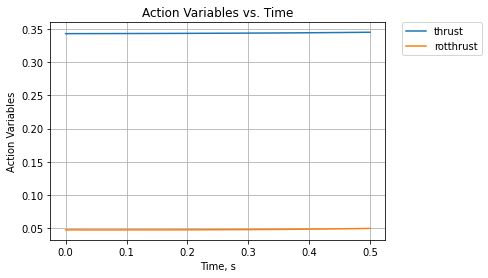

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[7] loss: 119.335


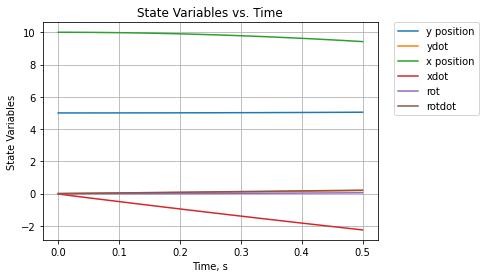

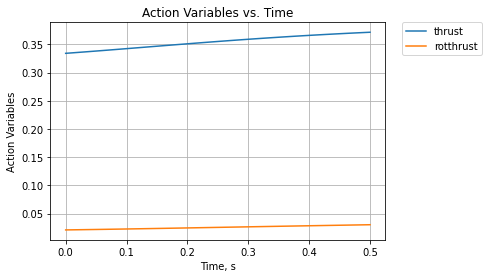

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[8] loss: 116.580


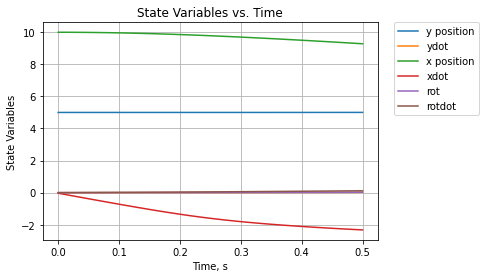

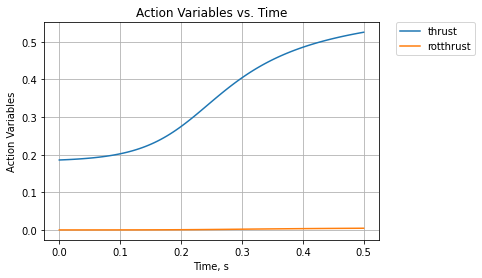

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[9] loss: 114.609


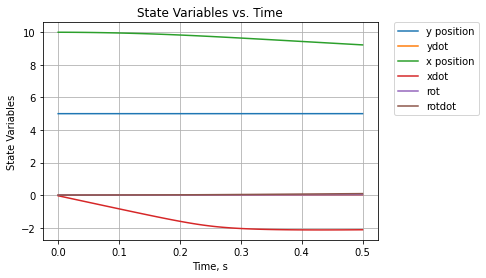

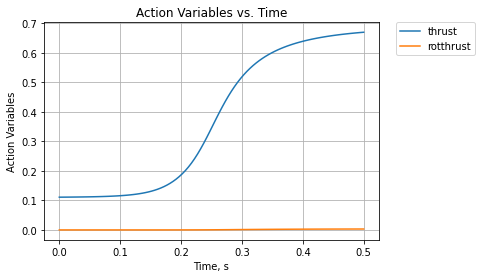

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[10] loss: 113.974


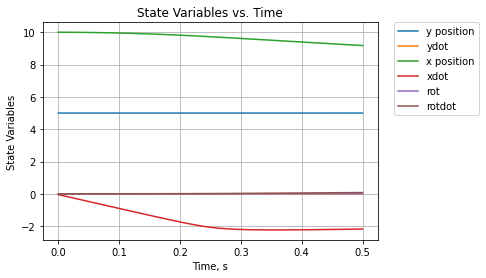

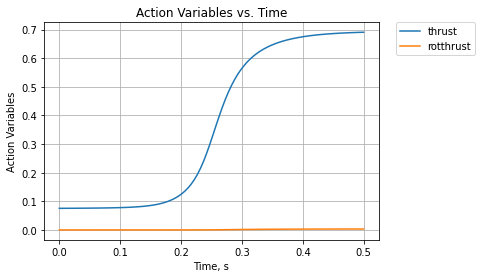

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[11] loss: 113.631


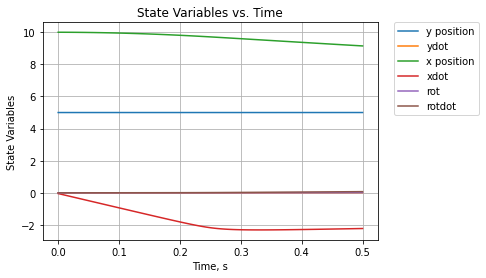

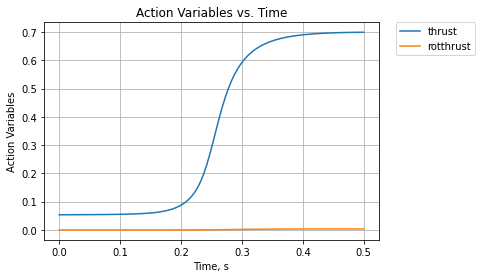

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[12] loss: 113.300


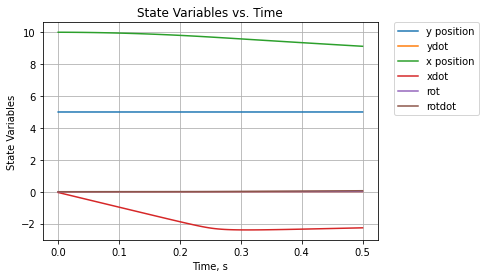

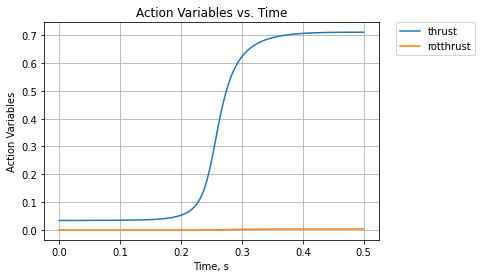

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[13] loss: 112.869


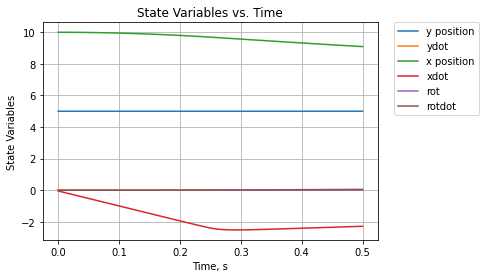

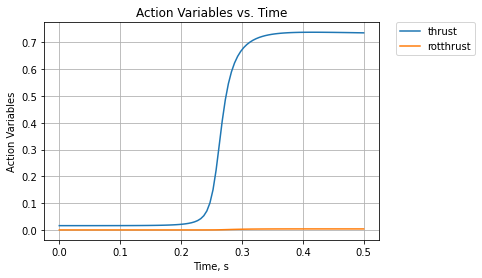

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[14] loss: 111.289


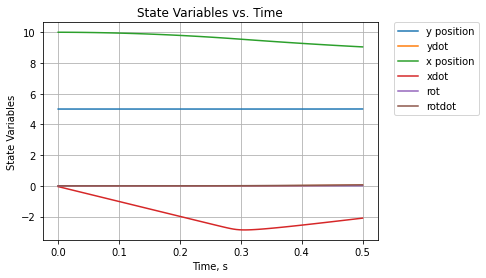

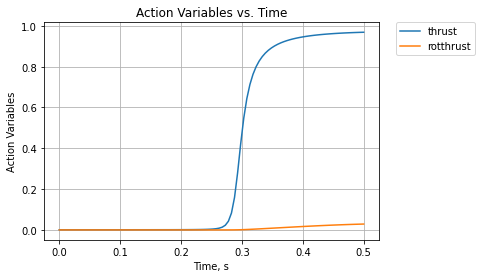

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[15] loss: 111.183


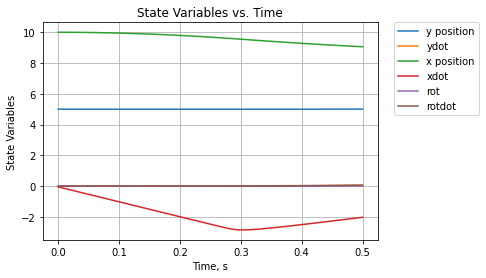

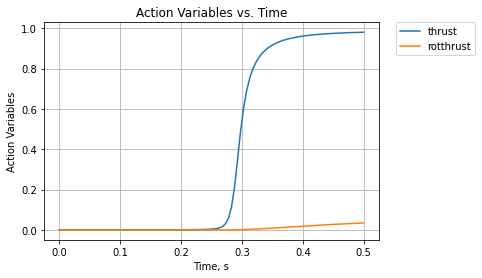

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[16] loss: 111.124


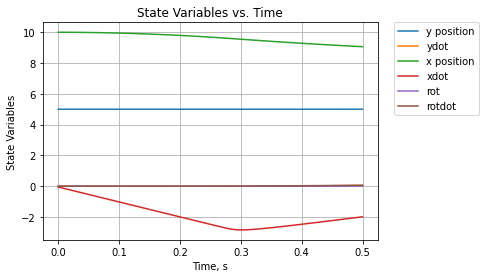

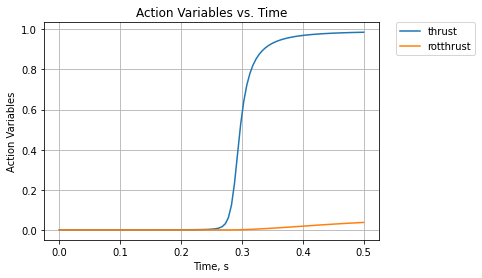

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[17] loss: 111.081


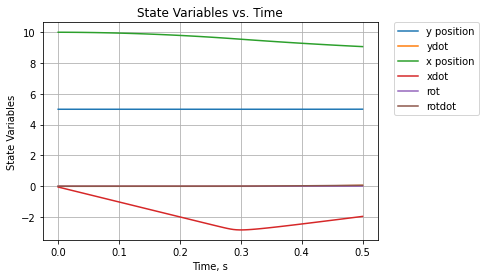

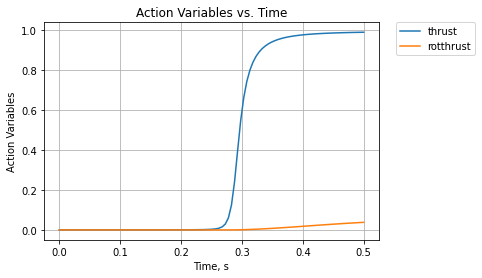

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[18] loss: 111.045


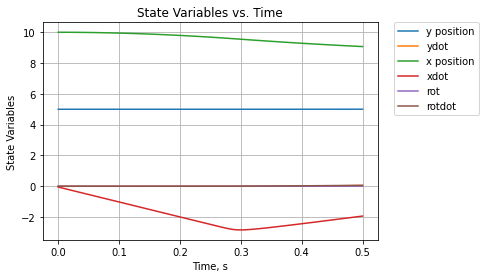

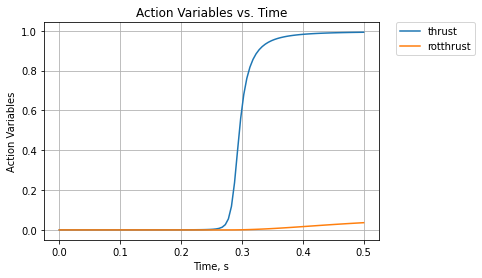

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[19] loss: 111.013


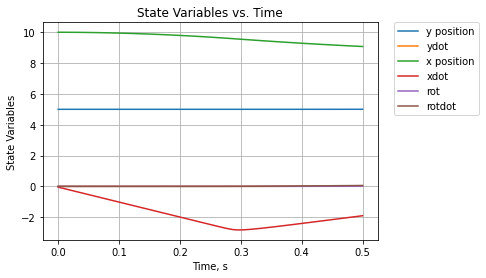

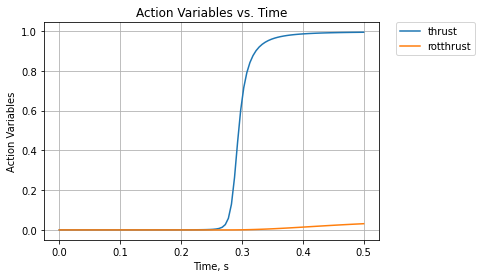

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[20] loss: 110.985


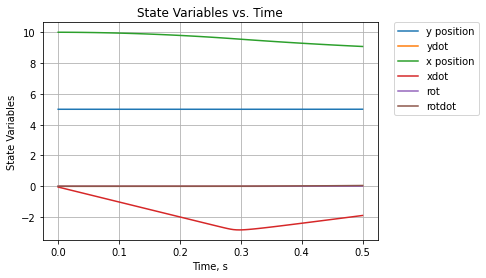

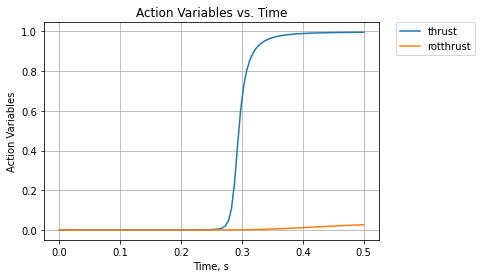

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[21] loss: 110.956


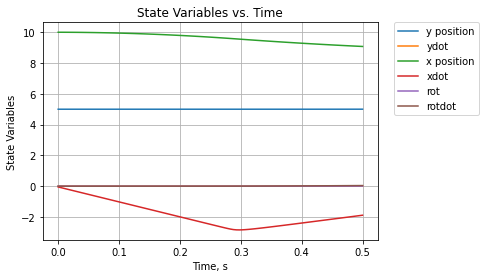

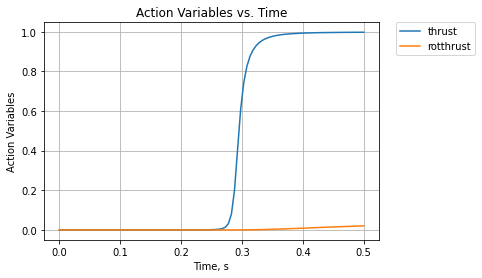

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[22] loss: 110.934


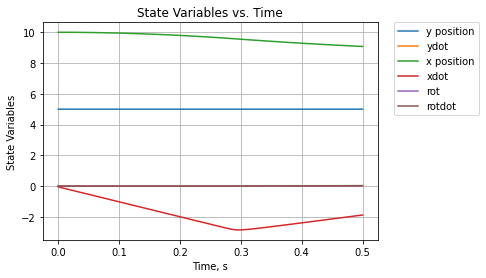

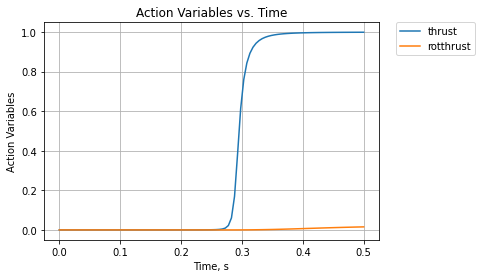

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[23] loss: 110.920


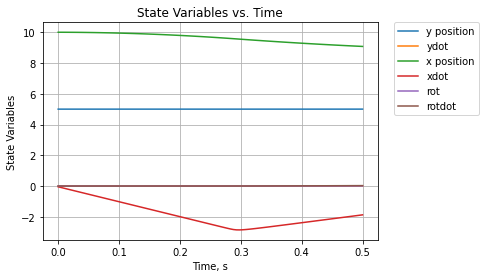

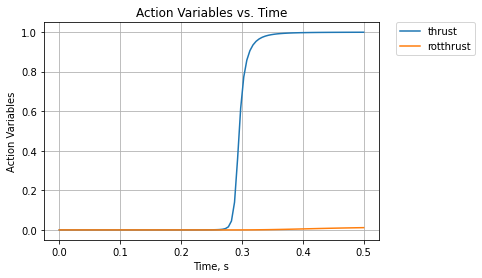

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[24] loss: 110.910


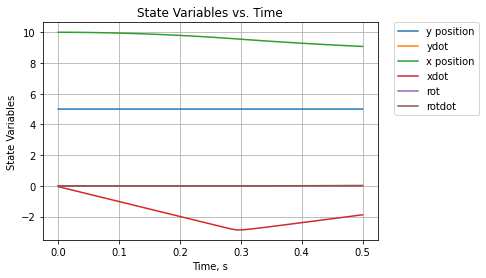

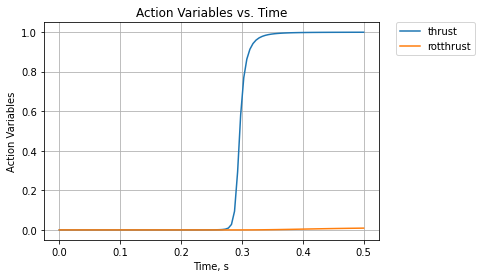

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[25] loss: 110.903


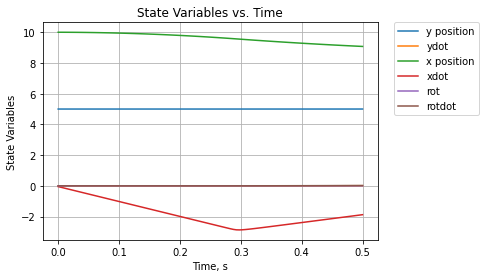

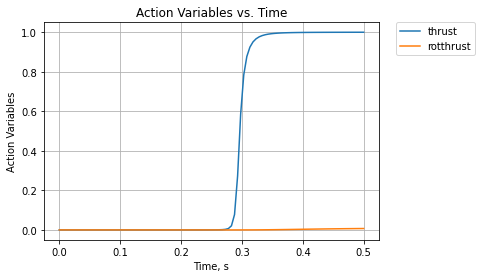

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[26] loss: 110.898


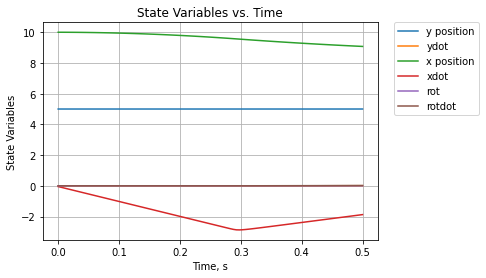

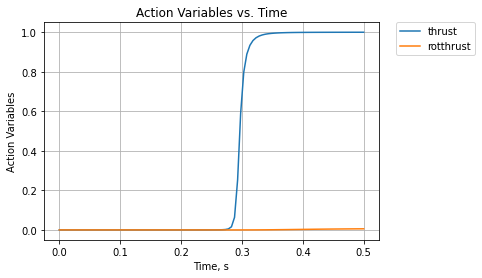

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[27] loss: 110.893


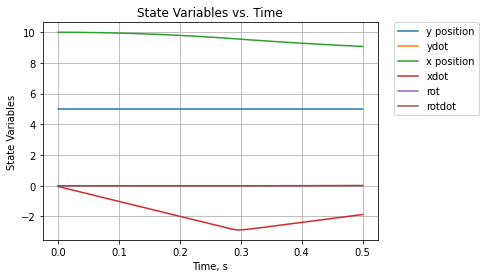

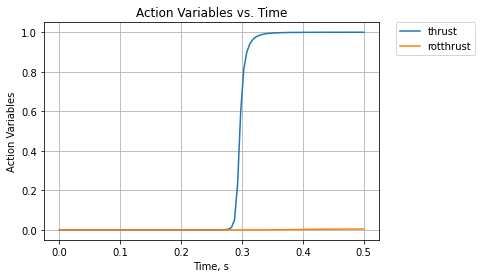

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[28] loss: 110.890


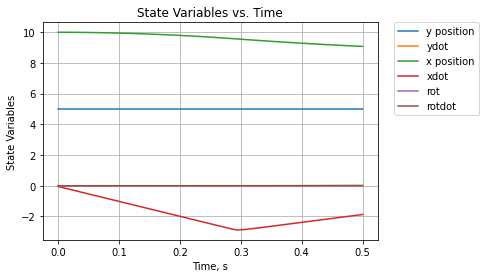

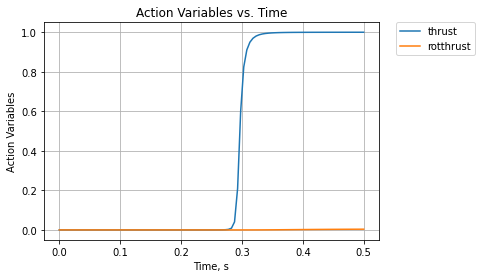

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[29] loss: 110.887


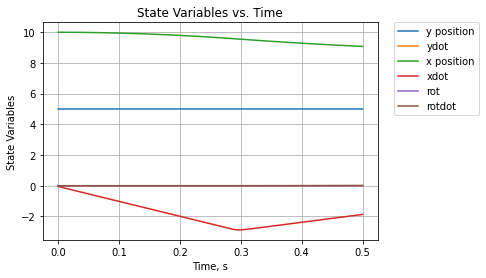

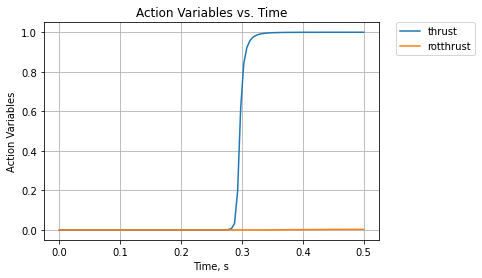

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[30] loss: 110.885


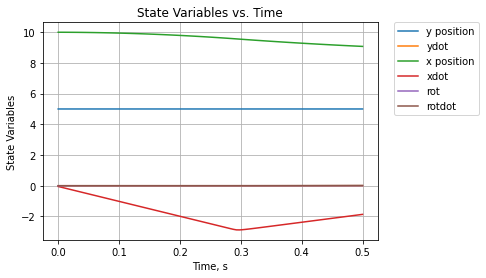

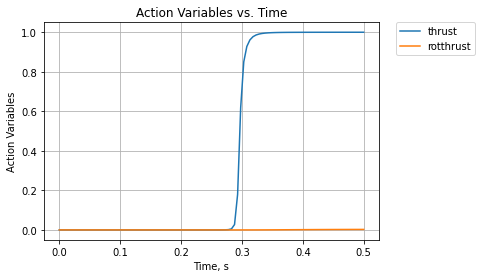

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[31] loss: 110.883


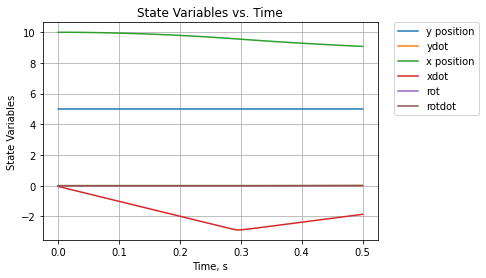

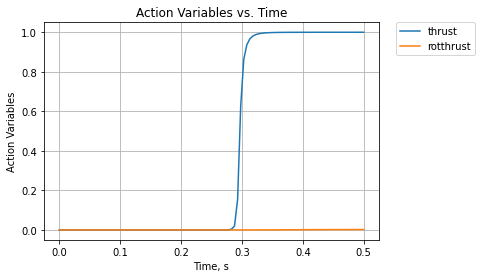

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[32] loss: 110.882


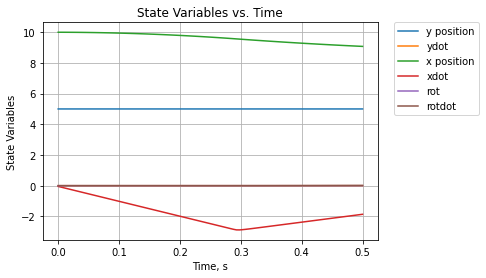

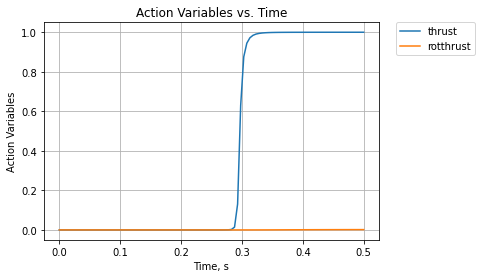

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[33] loss: 110.880


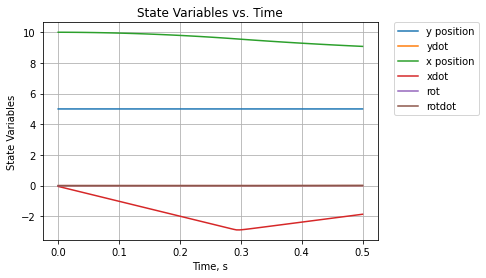

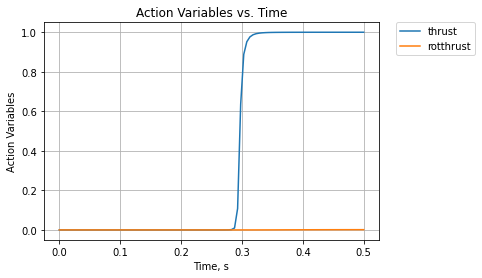

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[34] loss: 110.879


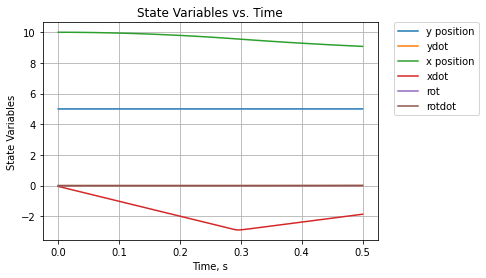

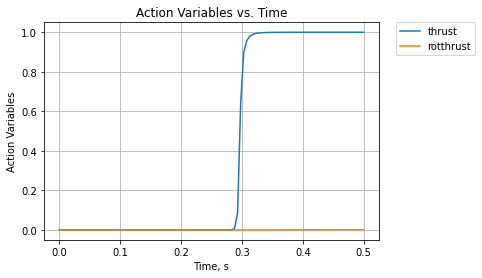

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[35] loss: 110.878


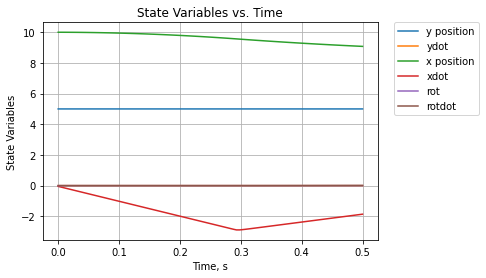

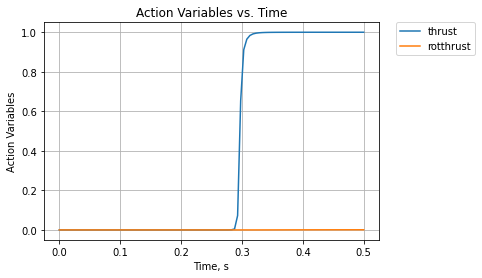

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[36] loss: 110.877


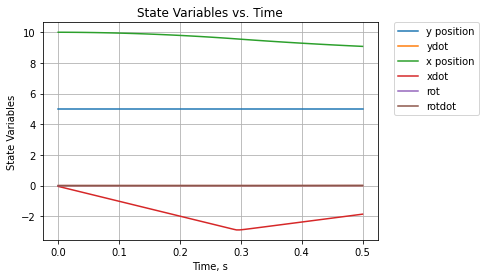

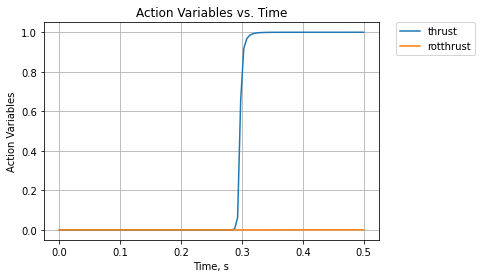

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[37] loss: 110.877


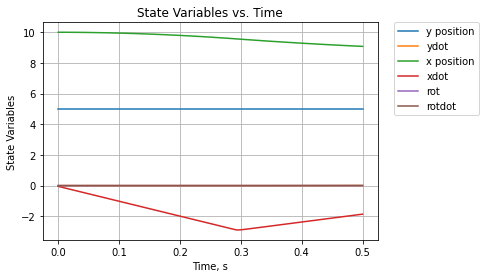

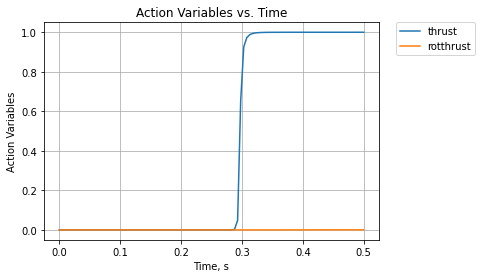

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[38] loss: 110.876


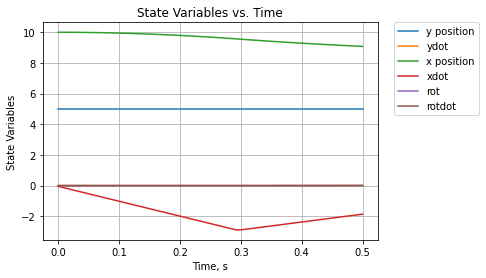

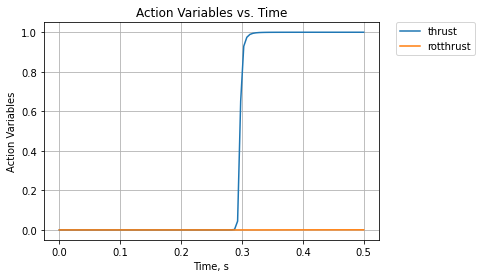

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[39] loss: 110.876


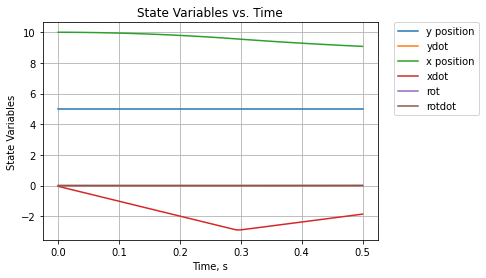

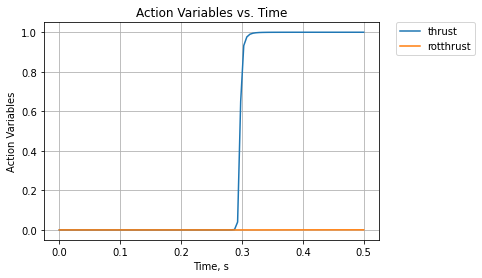

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[40] loss: 110.876


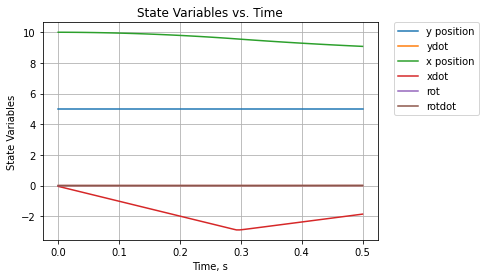

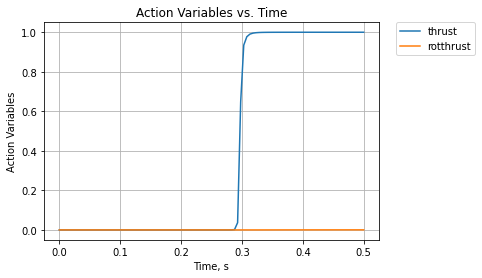

In [79]:
# Now it's time to run the code!
T = 100  # number of time steps
dim_input = 6  # state space dimensions
dim_hidden = 9  # latent dimensions
dim_output = 3  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem